# Математиката зад линейна и логистична регресия

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings(action="ignore", module="sklearn", message="^Objective did not")

%matplotlib inline

Ще се опитаме да формулиране проблема на линейната регресия по-формално. Ще вкараме някаква доза математика за да са по-точни нещата. След това ще се направим имплементация на базата на тази формула.

Нотацията леко ще се различава от тази в scikit-learn за да е консистентна с материала по темата (например курса на Andrew Ng).

Първо ще разгледаме линейна регресия с една променлива. Веднъж разбрали това, нещата се генерализират лесно.

# Нотация

Ще ползваме нотацията на Andrew Ng.

In [2]:
pd.DataFrame([[1, 2, 3, 6], [5, 6, 7, 18], [8, 9, 10, 27], [11, 12, 13, 36]], columns=['$x_1$', '$x_2$', '$x_3$', '$y$'], index=[1, 2, 3, 4])

,$x_1$,$x_2$,$x_3$,$y$
1,1,2,3,6
2,5,6,7,18
3,8,9,10,27
4,11,12,13,36


* $m$ е броя елементи в training set-а
* $n$ е броя feature-и
* $X$ е $m \times n$ матрица с стойностите на feature-ите за всеки ред
* $y$ е вектор с label-ите
* $x^{(i)}$ е $i$-тия ред от feature-ите. Обърнете внимание, че $(i)$ не е степен.
* $x^{(i)}_j$ е $j$-тия feature ($x_j$) на $i$-тия ред. Отново, $(i)$ не е степен.
* $y^{(i)}$ е $i$-тия target

Колко са $m$, $n$, $x^{(2)}$, $x^{(3)}_1$ и $y^{(1)}$?

$m = 4$, $n = 3$, $x^{(2)} = (5, 6, 7)$, $x^{(3)}_1 = 8$, $y^{(1)} = 6$

# Формулировка на проблема

Имаме някакви данни, за които ще търсим линейна функция, която ги апроксимира.

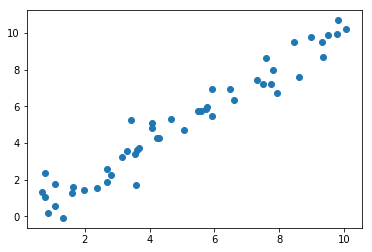

In [3]:
np.random.seed(0)
m = 50
points = np.linspace(0, 10, m).reshape(-1, 1) + np.random.randn(m, 2) * 0.5
X = points[:, 0].reshape(-1, 1)
y = points[:, 1]
plt.scatter(points[:, 0], points[:, 1]);

In [4]:
pd.DataFrame(points, columns=['$x_1$', '$y$'], index=range(1, m + 1)).head(20)

,$x_1$,$y$
1,0.882026,0.200079
2,0.693451,1.324528
3,1.341942,-0.080476
4,1.087289,0.536566
5,0.764717,1.021626
6,1.092430,1.747545
7,1.605009,1.285327
8,1.650503,1.595409
9,2.379693,1.530074
10,1.993269,1.409687


Ще наричаме функцията "хипотеза":

$$h_\theta(x) = \theta_0 + \theta_1 x_1$$

Тук:

* $\theta$ е вектор от коефициенти
* $h_\theta$ е хипотезата с определените в $\theta$ коефициенти
* $\theta_i$ е $i$-тия компонент на вектора $\theta$ (още $i$-тия коефициент)
* $\theta_0$ е свободния член във хипотезата

Друга нотация е $\hat y$, което е просто кратък запис на хипотезата са даден ред:

$$\hat y = h_\theta(x)$$

И разбира се:

$$\hat{y}^{(i)} = h_\theta(x^{(i)})$$

Ще е полезно за всяка хипотеза да имаме функция, която оценява колко добре се справя. Тази функция е добре да бъде неотрицателна, като по-малки стойности значат по-добро справяне. Ще я наричаме cost функция. За линейна регресия може да ползваме средната квадратна грешка:

$$
J(\theta)
= \frac{1}{2m}\sum_{i=1}^m \Big(\hat{y}^{(i)} - y^{(i)}\Big) ^ 2
= \frac{1}{2m}\sum_{i=1}^m \Big(h_\theta(x_1^{(i)}) - y^{(i)}\Big) ^ 2
$$

Така линейната регресия се свежда до много по-прост и разбираем проблем – да намерим глобален минимум на $J(\theta)$, който да ползваме.

Обърнете внимание, че:

* Функцията е винаги неотрицателна, т.е. оптималния възможен минимум за някакъв dataset е 0.
* Функцията е изпъкнала (всъщност, квадратна, макар и в две измерения), което ще рече, че има един минимум.
* 0 не е гарантиран минимум за всеки dataset. В интерес на истината, може да стигнем до 0 само ако всички точки лежат на една права.

Как да намерим минимум, обаче?

# Gradient Descent

Това е алгоритъм за намиране на минимум на функция. Не е нужно да знаем каква е функцията символично, а само да можем да я изчислим. Първоначално нека го разгледаме извън контекста на линейната регресия.

Ще трябва да си припомним малко училищен анализ.

In [5]:
def draw_derivative(func, x, bounds):
    (a, b) = bounds
    epsilon = (b - a) * 0.0001
    y = func(x)
    dx = (func(x + epsilon) - y) / epsilon
    di = y - dx * x
    
    xs = np.linspace(a, b, 400)
    ys = func(xs)
    
    span = ys.max() - ys.min()
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(xs, ys)
    plt.plot([x], [func(x)], marker='o', color='r')
    plt.plot(xs, (xs * dx + di), color='r')
    plt.grid()
    ax.axhline(color='k')
    ax.axvline(color='k')
    ax.set_ylim(ys.min() - 0.1 * span, ys.max() + 0.1 * span)

Ще разгледаме $x^2 + 0.2$ и нейната производна в някои точки. Тази функция също е изпъкнала.

Какъв е знака на производната в тази точка ($x = 1$)?

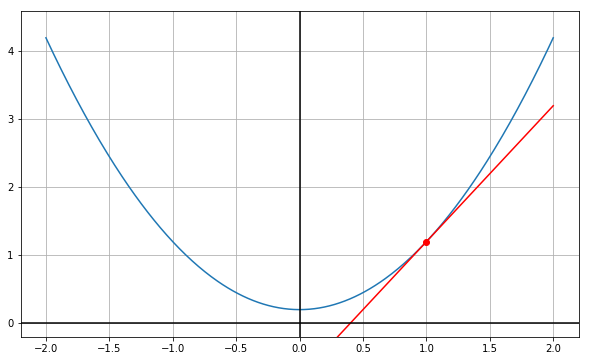

In [6]:
draw_derivative(lambda x: x**2 + 0.2, 1.0, (-2, 2))

Знакът е положителен, защото функцията расте.

Каква е стойността на променливата в тази точка ($x = 0.5$), сравнение с предишната?

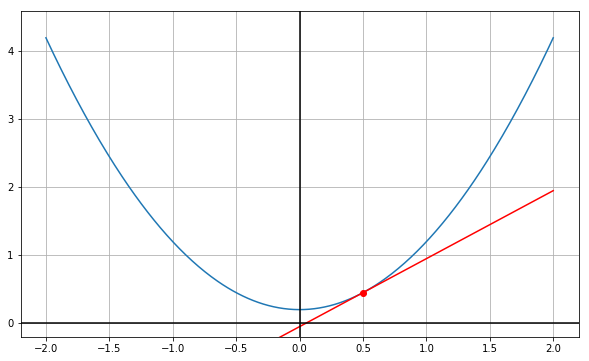

In [7]:
draw_derivative(lambda x: x**2 + 0.2, 0.5, (-2, 2))

Стойността е по-малка, понеже функцията расте по-бавно.

Какъв е знакът тук ($x = -1$)?

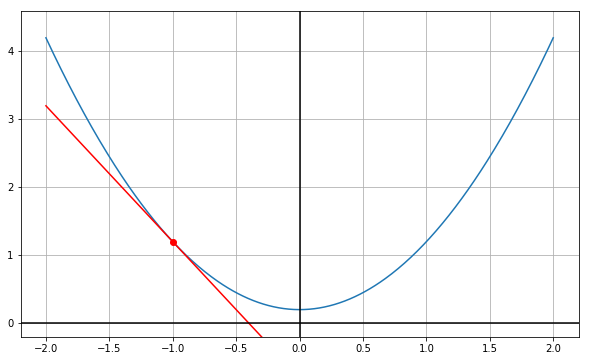

In [8]:
draw_derivative(lambda x: x**2 + 0.2, -1.0, (-2, 2))

Знакът е отрицателен, защото функцията намалява.

А тук ($x = 0$)?

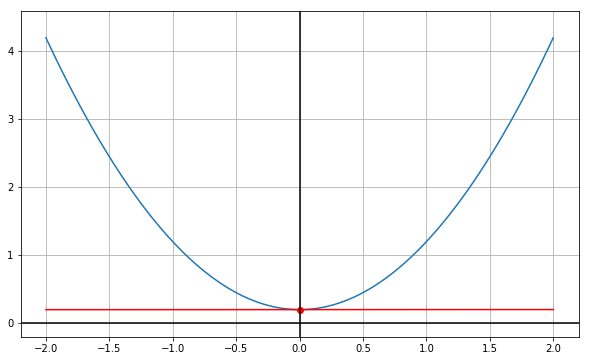

In [9]:
draw_derivative(lambda x: x**2 + 0.2, 0.0, (-2, 2))

Производната е 0, защото има локален минимум.

И финално, каква е връзката между стойността на производната в тази точка и червената права?

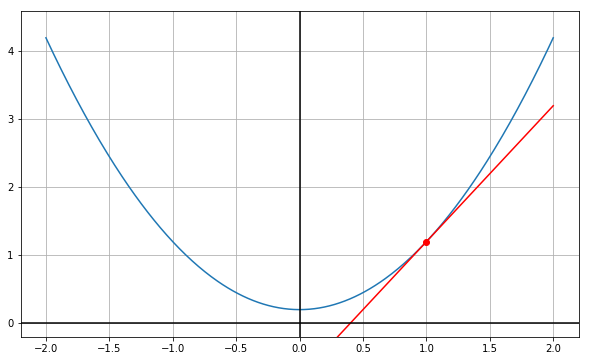

In [10]:
draw_derivative(lambda x: x**2 + 0.2, 1.0, (-2, 2))

Стойността на производната е тангенса на ъгъла между червената права и абцисата.

С други думи, производната в дадена точка ни дава информация в каква посока трябва да се предвижим, ако искаме се приближим към най-близкия локален минимум.

Просто трябва да повторим следната операция (с подходящо избрано число $\alpha$) определен брой пъти $N$:

$$ x := x - \alpha f'(x) $$

За начало може да инициализираме $x$ с произволна точка. При достатъчен брой итерации (и достатъчно малка $\alpha$) ще стигнем до минимума.

In [11]:
from itertools import tee

def pairwise(iterable):
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)

def draw_gradient_descent(func, start, alpha, iterations, region):
    (a, b) = region
    epsilon = 0.00001
    steps = [start]
    x = start

    for _ in range(iterations):
        dx = (func(x + epsilon) - func(x)) / epsilon
        x -= alpha * dx
        steps.append(x)
    
    xs = np.linspace(a, b, 400)
    ys = func(xs)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(xs, ys)
    plt.grid()
    ax.axhline(color='k')
    ax.axvline(color='k')
    
    for (xa, xb) in pairwise(steps):
        ya = func(xa)
        yb = func(xb)
        plt.annotate('', xy=(xa, ya), xycoords='data',
                         xytext=(xb, yb), textcoords='data', size=25,
                         arrowprops={'arrowstyle': '<-', 'ec': 'r', 'lw': 2})

Ако изберем $\alpha$ и $N$ подходящо, с градиентно спускане може да намерим минимума:

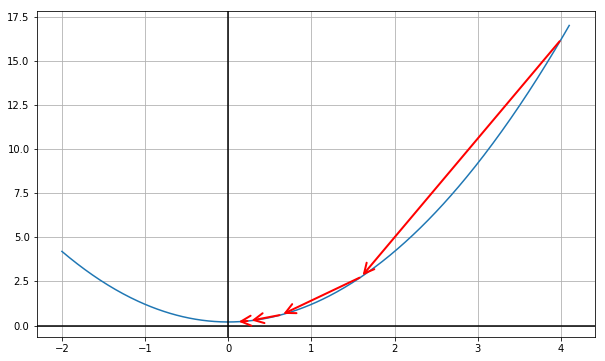

In [12]:
draw_gradient_descent(lambda x: x**2 + 0.2, start=4.0, alpha=0.3, iterations=4, region=(-2.0, 4.1))

Ако $\alpha$ е твърде малко, вероятно няма да ни стигнат итерациите:

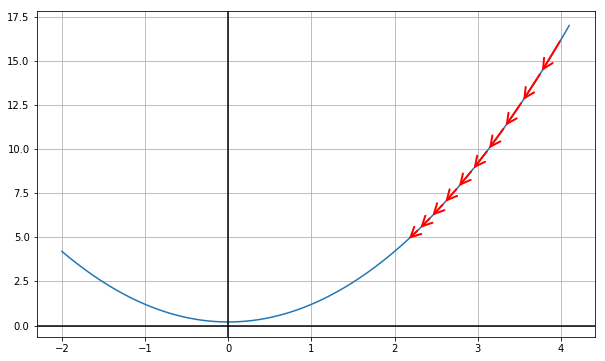

In [13]:
draw_gradient_descent(lambda x: x**2 + 0.2, start=4.0, alpha=0.03, iterations=10, region=(-2.0, 4.1))

Ако пък $\alpha$ е твърде голямо, резултатите ни няма да клонят към минимума и градиентното спускане ще го прескача постоянно.

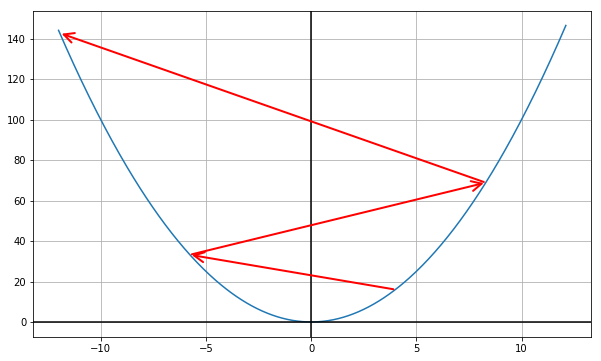

In [14]:
draw_gradient_descent(lambda x: x**2 + 0.2, start=4.0, alpha=1.22, iterations=3, region=(-12.0, 12.1))

Може да имплементираме прост алгоритъм, който взема производната на функция и работи с нея:

In [15]:
f = lambda x: x**2 + 2 * x + 1
df = lambda x: 2*x + 2

In [16]:
def gradient_descent(derivative, start, alpha, iterations):
    x = start
    for _ in range(iterations):
        x -= alpha * derivative(x)
    return x

In [17]:
x_min = gradient_descent(df, start=-10.0, alpha=0.1, iterations=1000)
x_min

-1.0000000000000004

In [18]:
f(x_min)

0.0

Ако не знаехме производната, можехме да се оправим и по селския начин:

In [19]:
def gradient_descent(func, start, alpha, iterations):
    epsilon = 0.0000001
    x = start
    for _ in range(iterations):
        dx = (func(x + epsilon) - func(x)) / epsilon
        x -= alpha * dx
    return x

In [20]:
x_min = gradient_descent(f, start=-10.0, alpha=0.01, iterations=1000)
x_min

-1.000000065177744

Резултата, разбира се, е по-неточен, защото така производната е по-неточна.

## Повече измерения

При повече измерения вземаме частните производни по всяко и създаваме вектор от тях. Този вектор ни е градиента, по който се движим:

$$ x_j := x_j - \alpha \frac{\partial}{\partial x_j}f(x) $$

Ако не помните какво е частна производна – третираме всички други променливи, освен $x_j$ като константи и дифиренцираме.

![](https://am207.github.io/2017/wiki/gradientdescent_files/gradientdescent_19_0.png)

# Gradient Descent върху линейна регресия

Връщайки се на линейната регресия, трябва да оптимизираме следната функция.

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^m \Big(h_\theta(x_1^{(i)}) - y^{(i)}\Big) ^ 2
$$

Тя е изпъкнала и неотрицателна. Трябва да й сметнем производната. Преди това, нека я променим малко.

За да може да работим в вектори, нека да въведем константен feature $x_0 = 1$, така че да имаме $x = (x_0, x_1) = (1, x_1)$.

По този начин работим с вектори с еднаква форма:

$$ x = (x_0, x_1) $$
$$ \theta = (\theta_0, \theta_1) $$

Тогава функцията е:

$$
J(\theta) = \frac{1}{2m}\sum_{i=1}^m \Big(h_\theta(x^{(i)}) - y^{(i)}\Big) ^ 2
$$

И:

$$
h_\theta(x) = \theta_0 x_0 + \theta_1 x_1
$$

Трябва да сметнем:

$$
\frac{\partial}{\partial \theta_j} J(\theta) =
  \frac{\partial}{\partial \theta_j} \frac{1}{2m}\sum_{i=1}^m \Big(h_\theta(x^{(i)}) - y^{(i)}\Big) ^ 2
$$

Да опростим тая сметка, нека да я видим само с един член от сумата:

$$
\begin{align*}
\frac{\partial}{\partial \theta_j}J(\theta) &=
     \frac{\partial}{\partial \theta_j}\frac{1}{2}\big(h_\theta(x) - y)\big)^2 \\
  &= 2 \cdot \frac{1}{2}\big(h_\theta(x) - y \big) \cdot \frac{\partial}{\partial \theta_j}\big(h_\theta(x) - y\big) \\
  &= \big(h_\theta(x) - y\big) \cdot \frac{\partial}{\partial \theta_j} \Bigg( \sum_{i=0}^n \theta_i x_i - y \Bigg) \\
  &= \big(h_\theta(x) - y\big) x_j
\end{align*}
$$

Частната производна по $\theta_j$ е:

$$
\frac{\partial}{\partial \theta_j}J(\theta) = \frac{1}{m}\sum_{i=1}^m\Big(\big(h_\theta(x^{(i)}) - y^{(i)}\big)x_j^{(i)}\Big)
$$

За градиентно спускане трябва да обновяваме коефициентите така:

$$
\begin{align*}
\theta_0 &:= \theta_0 - \alpha \frac{1}{m}\sum_{i=1}^m\big(h_\theta(x^{(i)}) - y^{(i)}\big) \\
\theta_1 &:= \theta_1 - \alpha \frac{1}{m}\sum_{i=1}^m\Big(\big(h_\theta(x^{(i)}) - y^{(i)}\big)x_1^{(i)}\Big)
\end{align*}
$$

Нека се опитаме да имплементираме тази сметка в NumPy с векторизация. Ще даваме стъпка по стъпка, за да е по-ясно.

Най-лесно ще е да илюстрираме това с dataset.

In [24]:
plt.rc('figure', figsize=(12, 8))

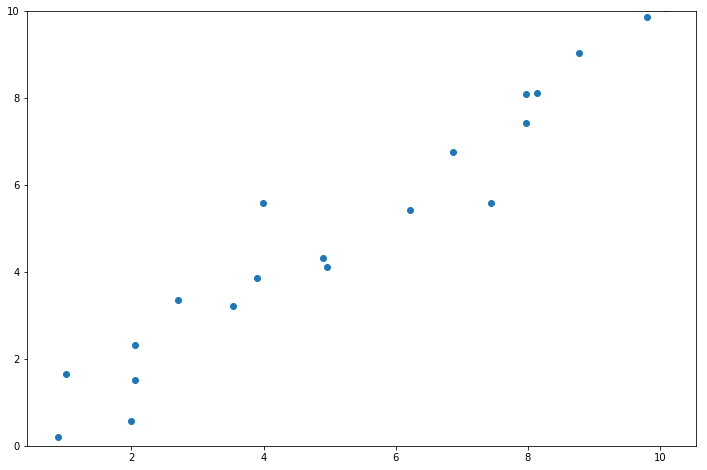

In [25]:
np.random.seed(0)
m = 20
line = np.linspace(0, 10, m)
points = np.random.randn(m, 2) * 0.5 + line.reshape(-1, 1)
X = np.hstack([np.ones((m, 1)), points[:, 0].reshape(-1, 1)])
y = points[:, 1]
plt.scatter(points[:, 0], points[:, 1])
plt.ylim(0, 10);

In [26]:
X

array([[  1.        ,   0.88202617],
       [  1.        ,   1.01568478],
       [  1.        ,   1.98641057],
       [  1.        ,   2.05399158],
       [  1.        ,   2.05365373],
       [  1.        ,   2.70360073],
       [  1.        ,   3.5384136 ],
       [  1.        ,   3.90614214],
       [  1.        ,   4.95756585],
       [  1.        ,   4.89337596],
       [  1.        ,   3.98666299],
       [  1.        ,   6.22169178],
       [  1.        ,   7.45066679],
       [  1.        ,   6.86498452],
       [  1.        ,   8.13481066],
       [  1.        ,   7.97221055],
       [  1.        ,   7.97715976],
       [  1.        ,   8.77341235],
       [  1.        ,  10.08882955],
       [  1.        ,   9.80633659]])

In [27]:
y

array([  0.2000786 ,   1.64676239,   0.56399264,   1.50326876,
         2.31056241,   3.3587157 ,   3.21873225,   3.85104769,
         4.10794718,   4.30979424,   5.58996719,   5.41839117,
         5.58860664,   6.74851334,   8.10310044,   8.0838181 ,
         7.4306544 ,   9.02554291,  10.07487413,   9.84884862])

Първо ще ползваме scikit-learn да натренираме една линейна регресия, за да видим какъв резултат тъсрим:

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(points[:, :-1], points[:, 1])
best_theta = np.array([model.intercept_, *model.coef_])
best_theta

array([-0.15200408,  0.98817937])

Ако я начертаем, изглежда убедително:

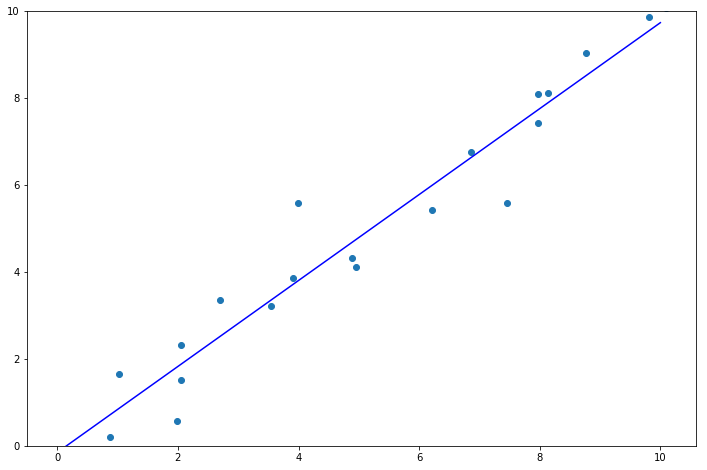

In [29]:
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line, best_theta[1] * line + best_theta[0], color='b')
plt.ylim(0, 10);

Ние, обаче, ще започнем с по-лоша $\theta$:

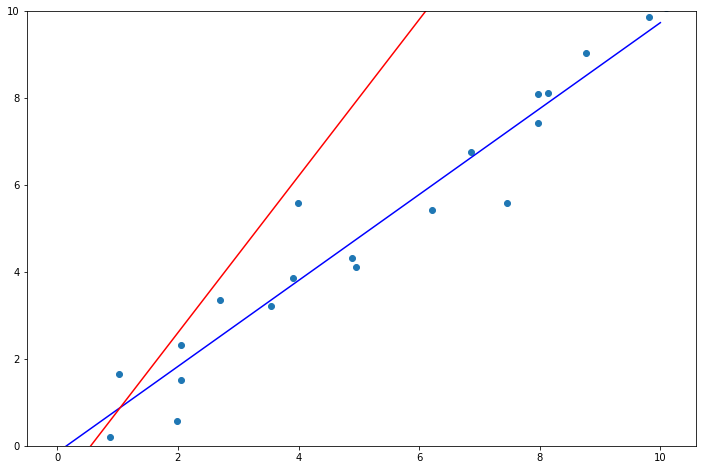

In [30]:
theta = np.array([-1., 1.8])
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line, best_theta[1] * line + best_theta[0], color='b')
plt.plot(line, theta[1] * line + theta[0], color='r')
plt.ylim(0, 10);

Сега ще стъпим през една итерация на gradient descent, опитвайки се да го имплементираме с NumPy.

Ще започнем с хипотезата:

$$
\frac{1}{m}\sum_{i=1}^m\Big(\big(\bbox[yellow]{h_\theta(x^{(i)})} - y^{(i)}\big)x_j^{(i)}\Big)
$$

Понеже $h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 = \theta^T x$, може да го пренапишем така:

$$
\frac{1}{m}\sum_{i=1}^m\Big(\big(\bbox[yellow]{\theta^T x^{(i)}} - y^{(i)}\big)x_j^{(i)}\Big)
$$

Резултата ще бъде NumPy масив с $m$ елемента, всеки от който съдържа предвидената стойност за ред от $X$:

In [31]:
X @ theta

array([  0.58764711,   0.82823261,   2.57553903,   2.69718484,
         2.69657672,   3.86648132,   5.36914448,   6.03105586,
         7.92361853,   7.80807672,   6.17599338,  10.19904521,
        12.41120021,  11.35697214,  13.64265919,  13.349979  ,
        13.35888756,  14.79214222,  17.15989319,  16.65140586])

Ще продължим с изваждането на $y$:

$$
\frac{1}{m}\sum_{i=1}^m\Big(\bbox[yellow]{\big(\theta^T x^{(i)} - y^{(i)}\big)}x_j^{(i)}\Big)
$$

Резултата вече трябва да бъде грешката за всеки от елементите:

In [32]:
X @ theta - y

array([ 0.38756851, -0.81852978,  2.01154639,  1.19391607,  0.38601431,
        0.50776562,  2.15041223,  2.18000817,  3.81567135,  3.49828249,
        0.58602618,  4.78065404,  6.82259358,  4.6084588 ,  5.53955875,
        5.2661609 ,  5.92823317,  5.76659932,  7.08501906,  6.80255724])

Нека добавим и умножението по $x_j$:

$$
\frac{1}{m}\sum_{i=1}^m\Big(\bbox[yellow]{\big(\theta^T x^{(i)} - y^{(i)}\big)x_j^{(i)}}\Big)
$$

Тук ще ползваме broadcasting. Резултата ще бъде $n \times m$ матрица, където всеки ред ще съдържа резултатите от това произведение за определен feature. Първия е за $x_0$, втория е за $x_1$:

In [33]:
(X @ theta - y) * X.T

array([[  0.38756851,  -0.81852978,   2.01154639,   1.19391607,
          0.38601431,   0.50776562,   2.15041223,   2.18000817,
          3.81567135,   3.49828249,   0.58602618,   4.78065404,
          6.82259358,   4.6084588 ,   5.53955875,   5.2661609 ,
          5.92823317,   5.76659932,   7.08501906,   6.80255724],
       [  0.34184557,  -0.83136824,   3.99575703,   2.45229356,
          0.79273973,   1.3727955 ,   7.60904789,   8.51542177,
         18.91644199,  17.1184114 ,   2.3362889 ,  29.74375594,
         50.83287136,  31.63699834,  45.06326157,  41.98294349,
         47.29046305,  50.59275365,  71.47954963,  66.70816597]])

Нека добавим и сумата:

$$
\frac{1}{m}\bbox[yellow]{\sum_{i=1}^m\Big(\big(\theta^T x^{(i)} - y^{(i)}\big)x_j^{(i)}\Big)}
$$

Резултата ще бъде масив с градиентите за всеки един от feature-ите. Да не забравяме да сумираме по правилната ос:

In [34]:
((X @ theta - y) * X.T).sum(1)

array([  68.49851638,  497.95043809])

Финално, трябва да разделим на m:

$$
\bbox[yellow]{\frac{1}{m}\sum_{i=1}^m\Big(\big(\theta^T x^{(i)} - y^{(i)}\big)x_j^{(i)}\Big)}
$$

In [35]:
((X @ theta - y) * X.T).sum(1) / m

array([  3.42492582,  24.8975219 ])

Може да ползваме този градиент да получим по-добро приближение на най-добрата линейна регресия:

In [36]:
gradient = ((X @ theta - y) * X.T).sum(1) / m
theta1 = theta - 0.02 * gradient
theta1

array([-1.06849852,  1.30204956])

Като го начертаем, виждаме, че новата линия е по-добра апроксимация

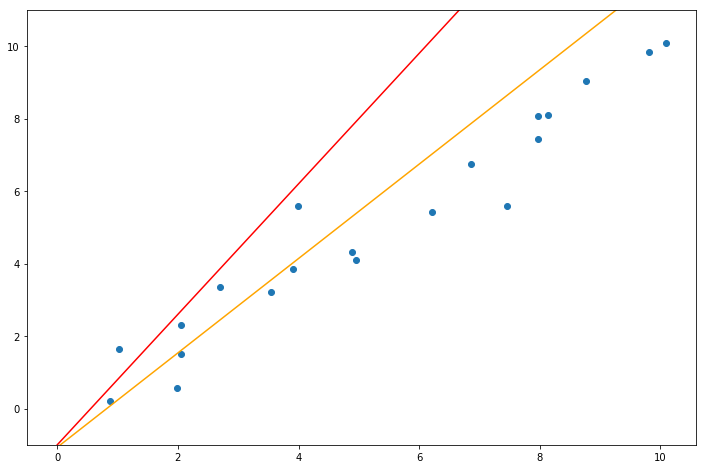

In [37]:
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line, theta[1] * line + theta[0], c='r')
plt.plot(line, theta1[1] * line + theta1[0], c='orange')
plt.ylim(-1, 11);

Ако итерираме още веднъж ще си приближим повече:

In [38]:
theta2 = theta1 - 0.02 * (((X @ theta1 - y) * X.T).sum(1) / m)
theta2

array([-1.083209  ,  1.17149397])

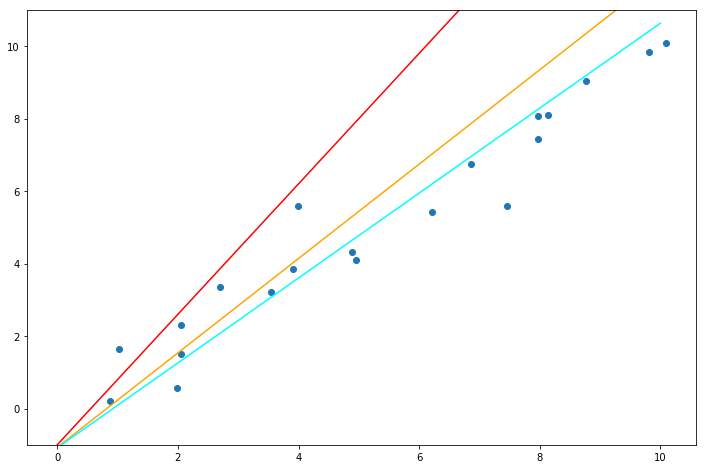

In [39]:
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line, theta[1] * line + theta[0], c='r')
plt.plot(line, theta1[1] * line + theta1[0], c='orange')
plt.plot(line, theta2[1] * line + theta2[0], c='cyan')
plt.ylim(-1, 11);

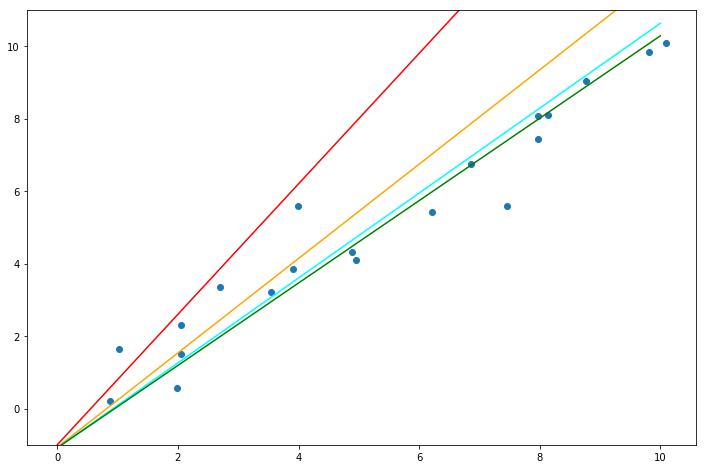

In [40]:
theta3 = theta2 - 0.02 * (((X @ theta2 - y) * X.T).sum(1) / m)
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line, theta[1] * line + theta[0], c='r')
plt.plot(line, theta1[1] * line + theta1[0], c='orange')
plt.plot(line, theta2[1] * line + theta2[0], c='cyan')
plt.plot(line, theta3[1] * line + theta3[0], c='green')
plt.ylim(-1, 11);

Все още има голяма разлика между това, което правим ние и това, което прави линейната регресия в scikit-learn.

In [41]:
theta3

array([-1.083882  ,  1.13692213])

In [42]:
best_theta

array([-0.15200408,  0.98817937])

Нека просто пуснем 10000 итерации и да видим какво ще стане:

In [43]:
result = theta
for _ in range(10000):
    gradient = ((X @ result - y) * X.T).sum(1) / m
    result -= 0.01 * gradient
    
result

array([-0.15200408,  0.98817937])

Това го намери и scikit-learn:

In [44]:
best_theta

array([-0.15200408,  0.98817937])

Нека пробваме да изчислим и $R^2$ score-а:

$$
\operatorname{R^2} =
 1 - \frac{\sum_{i=1}^n \big( \hat{y}_i - y_i \big)^2}{\sum_{i=1}^n \big( \bar{y} - y_i \big)^2}
$$

Където $\bar y$ е средно-аритметичното на y.

Да започнем с числителя:

$$
\sum_{i=1}^n \big( \bbox[yellow]{\hat{y}_i} - y_i \big)^2
$$

$\hat y$ е просто предвижданията на нашата функция, което е $X\theta^T$. Резултата трябва да е масив от $m$ елемента със предположението за всеки ред от $X$:

In [45]:
X @ theta

array([ 0.71959598,  0.85167466,  1.81092586,  1.87770801,  1.87737416,
        2.51963837,  3.34458322,  3.70796498,  4.74696019,  4.68352906,
        3.78753402,  5.99614336,  7.21059109,  6.63183197,  7.88664795,
        7.72596988,  7.73086058,  8.51770096,  9.8175691 ,  9.53841539])

Да започнем с числителя:

$$
\sum_{i=1}^n \big( \bbox[yellow]{\hat{y}_i - y_i} \big)^2
$$

Нека извадим $y$ за да получим грешката:

In [46]:
X @ theta - y

array([ 0.51951738, -0.79508773,  1.24693322,  0.37443925, -0.43318825,
       -0.83907733,  0.12585098, -0.14308271,  0.63901301,  0.37373483,
       -1.80243318,  0.57775218,  1.62198446, -0.11668137, -0.21645249,
       -0.35784822,  0.30020619, -0.50784194, -0.25730503, -0.31043324])

Трябва да повдигнем резултата на квадрат:

$$
\sum_{i=1}^n \bbox[yellow]{\big( \hat{y}_i - y_i \big)^2}
$$

In [47]:
(X @ theta - y) ** 2

array([ 0.2698983 ,  0.6321645 ,  1.55484245,  0.14020475,  0.18765206,
        0.70405076,  0.01583847,  0.02047266,  0.40833763,  0.13967772,
        3.24876535,  0.33379758,  2.63083358,  0.01361454,  0.04685168,
        0.12805535,  0.09012375,  0.25790344,  0.06620588,  0.0963688 ])

Финално, трябва да го сумираме, за да получим скалар:

$$
\operatorname{R^2} =
 1 - \frac{\bbox[yellow]{\sum_{i=1}^n \big( \hat{y}_i - y_i \big)^2}}{\sum_{i=1}^n \big( \bar{y} - y_i \big)^2}
$$

In [48]:
((X @ theta - y) ** 2).sum()

10.985659253836245

Знаменателя е тривиален и ще го направим наведнъж:

$$
\operatorname{R^2} =
 1 - \frac{\sum_{i=1}^n \big( \hat{y}_i - y_i \big)^2}{\bbox[yellow]{\sum_{i=1}^n \big( \bar{y} - y_i \big)^2}}
$$

In [49]:
((y.mean() - y) ** 2).sum()

176.27723221419529

Фималното изчисление е ясно:

$$
\operatorname{R^2} =
 1 - \frac{\sum_{i=1}^n \big( \hat{y}_i - y_i \big)^2}{\sum_{i=1}^n \big( \bar{y} - y_i \big)^2}
$$

In [50]:
1 - ((X @ theta - y) ** 2).sum() / ((y.mean() - y) ** 2).sum()

0.93767964747434018

Какво ли намери нашия scikit-learn по-рано?

In [51]:
model.score(points[:, :-1], points[:, 1])

0.93767964747434018

Същото! Колко яко!

# Estimator

Май събрахме достатъчно код да си направим собствен estimator.

Ще го даваме на YOLO и направо ще се опитаме да си имплементираме един:

In [52]:
from sklearn.base import BaseEstimator

class PoorMansLinearRegression(BaseEstimator):
    def __init__(self, alpha=0.01, iterations=2000):
        self.alpha = alpha
        self.iterations = iterations
    
    def fit(self, X, y):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        theta = np.random.rand(n + 1)
        for _ in range(self.iterations):
            gradient = ((X @ theta - y) * X.T).sum(1) / m
            theta -= self.alpha * gradient
            
        self.theta_ = theta
        
        return self
        
    def predict(self, X):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        return X @ self.theta_
    
    def score(self, X, y):
        X = np.hstack([np.ones((X.shape[0], 1)), X])
        return 1 - ((X @ self.theta_ - y) ** 2).sum() / ((y.mean() - y) ** 2).sum()

Отвъд малки дребни детайли, тук няма нищо интересно. Нека си вземем dataset-а с който почнахме, но да го направим малко по-подходящ за scikit-learn (без bias колоната):

In [53]:
X = points[:, :-1]
y = points[:, 1]

In [54]:
X

array([[  0.88202617],
       [  1.01568478],
       [  1.98641057],
       [  2.05399158],
       [  2.05365373],
       [  2.70360073],
       [  3.5384136 ],
       [  3.90614214],
       [  4.95756585],
       [  4.89337596],
       [  3.98666299],
       [  6.22169178],
       [  7.45066679],
       [  6.86498452],
       [  8.13481066],
       [  7.97221055],
       [  7.97715976],
       [  8.77341235],
       [ 10.08882955],
       [  9.80633659]])

In [55]:
y

array([  0.2000786 ,   1.64676239,   0.56399264,   1.50326876,
         2.31056241,   3.3587157 ,   3.21873225,   3.85104769,
         4.10794718,   4.30979424,   5.58996719,   5.41839117,
         5.58860664,   6.74851334,   8.10310044,   8.0838181 ,
         7.4306544 ,   9.02554291,  10.07487413,   9.84884862])

Да тренираме нашия регресор!

In [56]:
poor = PoorMansLinearRegression(alpha=0.02, iterations=10000)
poor.fit(X, y)
print(poor.predict(X))
poor.score(X, y)

[ 0.71959598  0.85167466  1.81092586  1.87770801  1.87737416  2.51963837
  3.34458322  3.70796498  4.74696019  4.68352906  3.78753402  5.99614336
  7.21059109  6.63183197  7.88664795  7.72596988  7.73086058  8.51770096
  9.8175691   9.53841539]


0.93767964747434018

Какво ли дава тоя на scikit-learn?

In [57]:
model = LinearRegression().fit(X, y)
print(model.predict(X))
model.score(X, y)

[ 0.71959598  0.85167466  1.81092586  1.87770801  1.87737416  2.51963837
  3.34458322  3.70796498  4.74696019  4.68352906  3.78753402  5.99614336
  7.21059109  6.63183197  7.88664795  7.72596988  7.73086058  8.51770096
  9.8175691   9.53841539]


0.93767964747434018

Бижу!

Я да го пробваме с "по-истински dataset":

In [58]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

boston = load_boston()
X = minmax_scale(boston.data)
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [59]:
proper = LinearRegression().fit(X_train, y_train)
proper.fit(X_train, y_train)
proper.score(X_test, y_test)

0.76596521056611888

Нека сега си натренираме с нашия estimator:

In [60]:
poor = PoorMansLinearRegression(alpha=0.5, iterations=50000)
poor.fit(X_train, y_train)
print("Our score:       {}".format(poor.score(X_test, y_test)))
print("sklearn's score: {}".format(proper.score(X_test, y_test)))

Our score:       0.7659652105661173
sklearn's score: 0.7659652105661189


In [61]:
print("Bigest error wrt sklearn: {0:.14f}".format(np.abs(proper.predict(X_test) - poor.predict(X_test)).max()))

Bigest error wrt sklearn: 0.00000000000054


# Normal equation method

Всъщност, има и друг подход с който може да решим проблема на линейната регресия – може просто да решим уравнението:

$$\frac{\partial}{\partial \theta_j}J(\theta) = 0 \space \space \space \space \text{(for every j)}$$

Ако приложим малко анализ, може да намерим символично решение. Ще ви спестим математиката, понеже включва добро количество векторен анализ, и ще ви покажем направо резултата:

$$\theta = (X^T X)^{-1}X^Ty$$

Обърнете внимане, че тази операция включва обръщане на матрица, което създава няколко проблема.

Първо, нека си възстановим dataset-а от по-рано с точките, за да го пробваме.

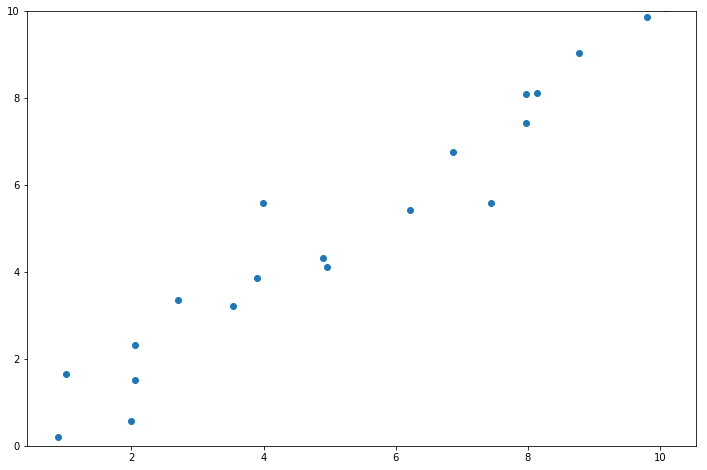

In [62]:
np.random.seed(0)
m = 20
line = np.linspace(0, 10, m)
points = np.random.randn(m, 2) * 0.5 + line.reshape(-1, 1)
plt.scatter(points[:, 0], points[:, 1])
plt.ylim(0, 10);

Нека си направим X и y:

In [63]:
X = np.hstack([np.ones((m, 1)), points[:, :-1]])
y = points[:, 1]

In [64]:
X

array([[  1.        ,   0.88202617],
       [  1.        ,   1.01568478],
       [  1.        ,   1.98641057],
       [  1.        ,   2.05399158],
       [  1.        ,   2.05365373],
       [  1.        ,   2.70360073],
       [  1.        ,   3.5384136 ],
       [  1.        ,   3.90614214],
       [  1.        ,   4.95756585],
       [  1.        ,   4.89337596],
       [  1.        ,   3.98666299],
       [  1.        ,   6.22169178],
       [  1.        ,   7.45066679],
       [  1.        ,   6.86498452],
       [  1.        ,   8.13481066],
       [  1.        ,   7.97221055],
       [  1.        ,   7.97715976],
       [  1.        ,   8.77341235],
       [  1.        ,  10.08882955],
       [  1.        ,   9.80633659]])

In [65]:
y

array([  0.2000786 ,   1.64676239,   0.56399264,   1.50326876,
         2.31056241,   3.3587157 ,   3.21873225,   3.85104769,
         4.10794718,   4.30979424,   5.58996719,   5.41839117,
         5.58860664,   6.74851334,   8.10310044,   8.0838181 ,
         7.4306544 ,   9.02554291,  10.07487413,   9.84884862])

Сега нека просто сметнем уравнението:

$$\theta = (X^T X)^{-1}X^Ty$$

In [66]:
theta = np.linalg.pinv(X.T @ X) @ X.T @ y
theta

array([-0.15200408,  0.98817937])

`LinearRegression` намира същите коефициенти:

In [67]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(points[:, :-1], points[:, 1])
np.array([model.intercept_, *model.coef_])

array([-0.15200408,  0.98817937])

Въпреки това, този метод има няколко проблема:

* Намирането на обратна матрица е бавна операция – $O(n^3)$. При твърде голяма матрица $X$ няма шанс да я изчакате.
* Ако имате линейни зависимости между feature-ите, матрицата ще е необратима.

# Регуляризация

Как изглежда регуляризацията при линейната регресия? Стандартната (l2) регуляризация просто ползва малко по-различна cost функция с допълнителен член:

$$
J(\theta) = \frac{1}{2m} \Bigg[ \sum_{i=1}^m \Big(h_\theta(x^{(i)}) - y^{(i)}\Big) ^ 2 + \lambda \sum_{j=1}^n\theta_j^2 \Bigg]
$$

По този начин се опитваме да държим коефициентите на линейната регресия малки. $\lambda$ е регуляризационния параметър (`C` или `alpha` в scikit-learn).

Частната производна и градиента изглеждат малко по-различно:

$$
\theta_j := \theta_j - \alpha \Bigg[
 \Bigg (\frac{1}{m}\sum_{i=1}^m\Big(\big(h_\theta(x^{(i)}) - y^{(i)}\big)x_j^{(i)}\Big) \Bigg) +
 \frac{\lambda}{m}\theta_j \Bigg]
$$

Нека натренираме един `Ridge`, за да има с какво да сравняваме:

In [68]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

X = minmax_scale(boston.data, (-1, 1))
y = boston.target

grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]}
search = GridSearchCV(Ridge(), grid)
search.fit(X, y)
search.best_estimator_

Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [69]:
ridge = Ridge(alpha=10).fit(X, y)
ridge.score(X, y)

0.72884850238173338

Сега ще си направим наша регуляризация:

In [70]:
from sklearn.base import RegressorMixin

class Regularized(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=0.01, l=0, iterations=20000):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
    
    def fit(self, X, y):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        theta = np.random.rand(n + 1)
        for _ in range(self.iterations):
            regularization = self.l / m * theta
            regularization[0] = 0
            gradient = ((X @ theta - y) * X.T).sum(1) / m + regularization
            theta -= self.alpha * gradient
            
        self.theta_ = theta
        
        return self
        
    def predict(self, X):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        return X @ self.theta_

Може да ползваме този регресор с `GridSearchCV`:

In [71]:
grid = {'l': [0.1, 1.0, 10.0, 100.0]}
search = GridSearchCV(Regularized(alpha=0.1, iterations=20000), grid)
search.fit(X, y)
search.best_estimator_

Regularized(alpha=0.1, iterations=20000, l=10.0)

Сравнявайки резултатите с `Ridge`, получаваме нещо сходно:

In [72]:
poor = Regularized(alpha=0.1, iterations=20000, l=10.0).fit(X, y)
poor.score(X, y)

0.72884850238173393

In [73]:
ridge.score(X, y)

0.72884850238173338

# Логистична регресия

Логистичната регресия строи ползва хипотеза като линейната, но прекаране през сигмоид:

$$ h_\theta(x) = g(\theta^Tx) = g(\theta_0 + \theta_1 x_1 + \theta_2 x_2 + \ldots + \theta_n x_n) $$

Където:

$$ g(z) = \frac{1}{1 + e^{-z}} $$

Ще си дефинираме функцията за сигмоида:

In [74]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

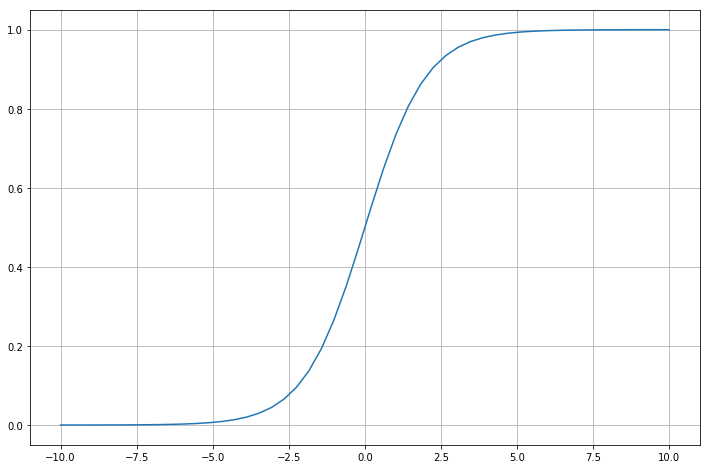

In [75]:
_x = np.linspace(-10, 10)
plt.plot(_x, [sigmoid(i) for i in _x])
plt.grid()

За cost функция използваме:

$$
\begin{align*}
& J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\mathrm{Cost} \big( h_\theta(x^{(i)}), y^{(i)}) \big) \\
& \mathrm{Cost}(h_\theta(x), y) = -log(1 - h_\theta(x)) & \text{if y = 0} \\
& \mathrm{Cost}(h_\theta(x), y) = -log(h_\theta(x)) & \text{if y = 1}
\end{align*}
$$

Може да я запишем и така:

$$
J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} \Big[
  y^{(i)}\log(h_\theta(x^{(i)})) +
  (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))
\Big]
$$

Или векторно:

$$
\begin{align*}
& h = g(X\theta) \\
& J(\theta) = \frac{1}{m} \cdot \Big( -y^T \log(h) - (1 - y)^T\log(1 - h) \Big)
\end{align*}
$$

Градиента е:

$$
\theta_j := \theta_j - \frac{\alpha}{m}\sum_{i=1}^{m}\Big(h_\theta(x^{(i)}) - y^{(i)}\Big)x^{(i)}_j
$$

Нека се опитаме да имплементираме и това. Първо ще започнем с някакъв dataset:

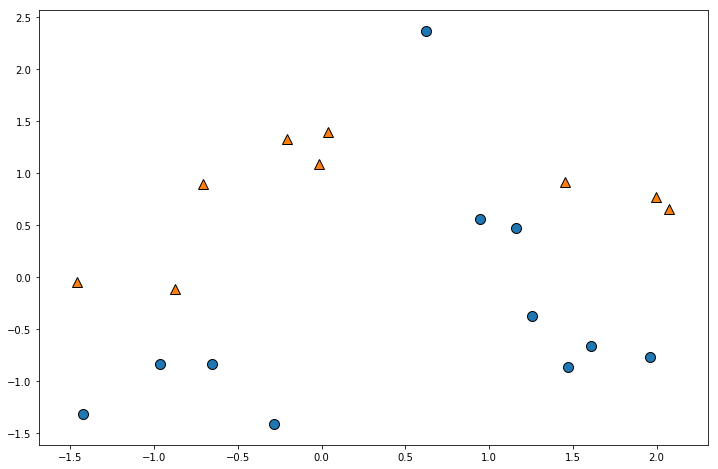

In [76]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=20, n_features=2, n_redundant=0, random_state=42)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y);

In [77]:
X = np.hstack([np.ones((X.shape[0], 1)), X])
(m, n) = X.shape

In [78]:
X

array([[ 1.        , -0.28280607, -1.40876083],
       [ 1.        ,  0.94702918,  0.55906844],
       [ 1.        ,  1.15772163,  0.474995  ],
       [ 1.        ,  1.99591479,  0.77282149],
       [ 1.        ,  0.04049985,  1.39732687],
       [ 1.        ,  1.47044441, -0.86055081],
       [ 1.        , -0.70743459,  0.89217168],
       [ 1.        , -1.45694256, -0.04564786],
       [ 1.        ,  0.62203454,  2.36749526],
       [ 1.        , -0.01544395,  1.09258513],
       [ 1.        ,  1.61125245, -0.65678116],
       [ 1.        ,  1.45454184,  0.91354664],
       [ 1.        , -0.20714752,  1.33055499],
       [ 1.        ,  1.9632335 , -0.7697201 ],
       [ 1.        , -0.96400678, -0.82990054],
       [ 1.        ,  2.07569216,  0.66009587],
       [ 1.        , -0.65503537, -0.83585632],
       [ 1.        , -1.42571554, -1.31373391],
       [ 1.        , -0.87496777, -0.11350669],
       [ 1.        ,  1.25579369, -0.37205015]])

Ще започнем с някаква хипотеза:

In [79]:
theta = np.random.rand(n)

Градиента ще се опитаме да го напишем наведнъж:

$$
\theta_j := \theta_j - \frac{\alpha}{m}\sum_{i=1}^{m}\Big(h_\theta(x^{(i)}) - y^{(i)}\Big)x^{(i)}_j
$$

In [80]:
((sigmoid(X @ theta) - y).reshape(-1, 1) * X).sum(0)

array([ 5.02868536,  5.99244749, -2.07551026])

Да пуснем няколко итерации:

In [81]:
theta = np.random.rand(n)
for _ in range(50000):
    theta -= 0.3 * ((sigmoid(X @ theta) - y).reshape(-1, 1) * X).sum(0) / m
theta

array([-0.31101828, -0.51404391,  1.5884362 ])

Да видим какво ще направи логистичната регресия.

In [82]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(C=1000000000000).fit(X[:, 1:], y)
np.array([log.intercept_[0], *log.coef_[0]])

array([-0.31101691, -0.51404307,  1.58843253])

Тук резултатите се различават малко повече, защото има регуляризация. Голямо `C` значи малка регуляризация (но все пак, не и 0).

Ще си напишем логистична регресия с регуляризация. Ето го градиента:

$$
\theta_j := \theta_j - \frac{\alpha}{m} \Bigg[ \sum_{i=1}^{m}\Big(h_\theta(x^{(i)}) - y^{(i)}\Big)x^{(i)}_j + \lambda\theta_j \Bigg]
$$

Абсолютно същото като линейната.

In [83]:
from sklearn.base import ClassifierMixin

class ItsSomethingLogistic(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0.01, l=1.0, iterations=20000):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
    
    def fit(self, X, y):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        theta = np.random.rand(n + 1)
        for _ in range(self.iterations):
            regularization = self.l / m * theta
            regularization[0] = 0
            gradient = ((sigmoid(X @ theta) - y).reshape(-1, 1) * X).sum(0) / m + regularization
            theta -= self.alpha * gradient
            
        self.theta_ = theta
        
        return self
        
    def predict(self, X):
        (m, n) = X.shape
        X = np.hstack([np.ones((m, 1)), X])
        
        return np.round(sigmoid(X @ self.theta_))

Може да тестваме нашия класификатор на cancer dataset-а:

In [84]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = minmax_scale(cancer.data, (-1, 1))
y = cancer.target

Ще ни трябват повече итерации, смела $\alpha$ и никаква регуляризация:

In [85]:
np.random.seed(0)

In [86]:
ours = ItsSomethingLogistic(l=0.0, alpha=20.0, iterations=500000)
ours.fit(X, y)
ours.score(X, y)

0.99648506151142358

Да видим какъв резултат вади `scikit-learn`:

In [87]:
LogisticRegression(C=10000).fit(X, y).score(X, y)

0.99648506151142358

Чудесно! Вадим същото, макар и много по-бавно.

# Въпроси